# install package

In [1]:
! pip install .

Processing /home/jovyan/work/latent-dirichlet-allocation
  Running setup.py bdist_wheel for lda-package ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/55/df/03/5c2615a45fff840cc1dac92c4e9d5fa0e8c00f0d88616624ee
Successfully built lda-package
  Found existing installation: lda-package 1.0
    Uninstalling lda-package-1.0:
      Successfully uninstalled lda-package-1.0


In [2]:
import lda_package

In [3]:
import numpy as np
from scipy.special import digamma, polygamma

# Simulated data example

In [325]:
   
# create sample documents
doc_a = """TheWilliam Randolph Hearst Foundation will give 1.25 million to Lincoln Center, Metropolitan
        Opera Co., New York Philharmonic and Juilliard School."""
doc_b = """ “Our board felt that we had a real opportunity to make a mark on the future of the performing 
           arts with these grants an act every bit as important as our traditional areas of support in health, 
           medical research, education and the social services,” Hearst Foundation President Randolph A. Hearst 
           said Monday in announcing the grants."""
doc_c = """Lincoln Center’s share will be 200000 for its new building, which
           will house young artists and provide new public facilities."""
doc_d = """The Metropolitan Opera Co. and New York Philharmonic will receive 400000 each."""
doc_e = """The Juilliard School, where music and the performing arts are taught, will get 250000. """
doc_f = """The Hearst Foundation, a leading supporter of the Lincoln Center Consolidated Corporate Fund, 
           will make its usual annual $100,000 donation, too."""

doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e, doc_f]

# Clean Data

In [326]:
# pip install nltk
# pip install stop-words
# easy_install -U gensim

In [343]:
def data_clean(doc_set, stop_word = None):
    
    """
    REF: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
    
    input: 
    doc_set: a list of documets, the elements are context of that document
    stop_word: if 'stop_word = None', this function will give a sample
    
    output: 
    texts:a list of array(documents), each element contains all words in that document
    dictionary: a dictionary, key is the id of words, values are unique words
    corpus: a list of list, each inner list represents a document. In the inner list, each tuple is (word_id, word_count)
    
    """
    
    from nltk.tokenize import RegexpTokenizer
    from stop_words import get_stop_words
    from nltk.stem.porter import PorterStemmer
    from gensim import corpora, models
    import gensim
    
    tokenizer = RegexpTokenizer(r'\w+')
    
    # create English stop words list
    if stop_word==None:
        stop_word = get_stop_words('en')
        
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []

    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in stop_word]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
        # add tokens to list
        if len(stemmed_tokens) > 0:
            texts.append(stemmed_tokens)

        # turn our tokenized documents into a id <-> term dictionary
        dictionary = corpora.Dictionary(texts)
    
        # convert tokenized documents into a document-term matrix
        corpus = [dictionary.doc2bow(text) for text in texts]
    
    return texts, dictionary, corpus


In [344]:
def data_process(texts, dictionary):

    """
    transform the texts from word-formation into id-formation, which can be used in function variantion_EM()
    
    """
    import numpy as np
    
    text_ = []
    for i in range(len(texts)):
        text_i = []
        for l in range(len(texts[i])):
            text_i = np.append(text_i, dictionary.token2id[texts[i][l]])
        text_.append(text_i)
            
    return text_

In [329]:
texts, dictionary, corpus = data_clean(doc_set)
text_ = data_process(texts, dictionary)

# Experimental test

In [330]:
np.random.seed(64528)

M = 6
k = 4
N = np.array(list(map(len, text_)))
V = len(dictionary)
V_words = range(V)
alpha = np.random.dirichlet(10*np.ones(k),1)[0]
beta = np.random.dirichlet(np.ones(V),k)

phi = np.array([1/k*np.ones([N[m],k]) for m in range(M)])
gamma = np.tile(alpha,(M,1)) + np.tile(N/k,(k,1)).T

In [331]:
ans = lda_package.variation_EM(M, k, text_, N, V_words, alpha, beta, gamma, phi, iteration = 1000)

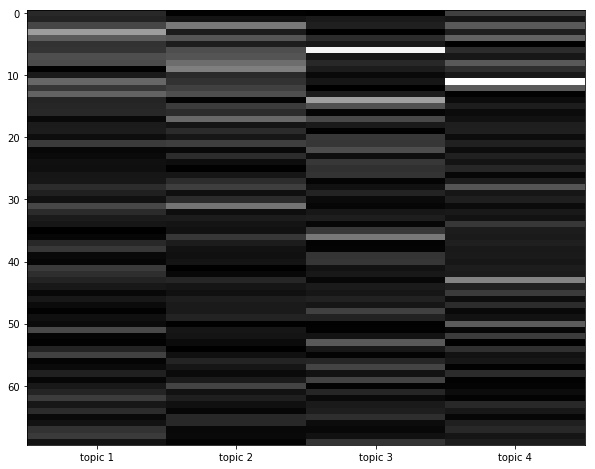

In [464]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(ans[1].T,cmap=plt.cm.gray, interpolation='nearest', aspect='auto')
plt.xticks([0, 1, 2, 3], ["topic 1", "topic 2","topic 3", "topic 4"])
pass

In [333]:
m = dictionary.token2id
id2token = dict(zip(m.values(), m.keys()))

In [334]:
order = list(map(np.argsort, ans[1]))
for i in range(len(order)):
    print("topic", (i+1), "\n", ans[1][i][order[i][-1]], "*", id2token[order[i][-1]], "+",
          ans[1][i][order[i][-2]], "*", id2token[order[i][-2]], "+",
          ans[1][i][order[i][-3]], "*", id2token[order[i][-3]], "+",
          ans[1][i][order[i][-4]], "*", id2token[order[i][-4]], '\n')

topic 1 
 0.06258035061866102 * co + 0.0411663679334841 * new + 0.03960874829765505 * philharmon + 0.03625888930214377 * foundat 

topic 2 
 0.0507455950628512 * metropolitan + 0.048846017700947916 * center + 0.04632554625666445 * make + 0.043617625645694255 * lincoln 

topic 3 
 0.09738722371507769 * hearst + 0.06356043359084296 * randolph + 0.04782145548524448 * perform + 0.03565054837060334 * share 

topic 4 
 0.10152731463363168 * new + 0.052564459004376 * support + 0.03927570181943087 * foundat + 0.03687693265489178 * provid 



# Real world data

In [338]:
f = open('Test_data/vocab.txt', 'r')
vocab = f.read().splitlines()
f.close()

In [345]:
f = open('Test_data/ap.txt', 'r')
ap = f.read().splitlines()
f.close()

In [346]:
f = open('stop_word.txt', 'r')
stop_word = f.read().splitlines()
#stop_word = list(map(stop_word, strip)
f.close()

In [347]:
stop_word = [word.strip() for word in stop_word]

In [348]:
texts, dictionary, corpus = data_clean(ap, stop_word)
text_ = data_process(texts, dictionary)

In [351]:
file=open('text_real_world.txt','w')  
file.write(str(text_));  
file.close()

In [375]:
np.random.seed(10986)

M = len(texts)
k = 10
N = np.array(list(map(len, text_)))
V = len(dictionary)
V_words = range(V)
alpha = np.random.dirichlet(10*np.ones(k),1)[0]
beta = np.random.dirichlet(np.ones(V),k)

phi = np.array([1/k*np.ones([N[m],k]) for m in range(M)])
gamma = np.tile(alpha,(M,1)) + np.tile(N/k,(k,1)).T

In [376]:
ans_real_world = lda_package.variation_EM(M, k, text_, N, V_words, alpha, beta, gamma, phi, iteration = 200)
file=open('ans_real_world.txt','w')  
file.write(str(ans_real_world));  
file.close()

# Visualization

In [384]:
beta_post = ans_real_world[1]

IndexError: index 9 is out of bounds for axis 0 with size 9

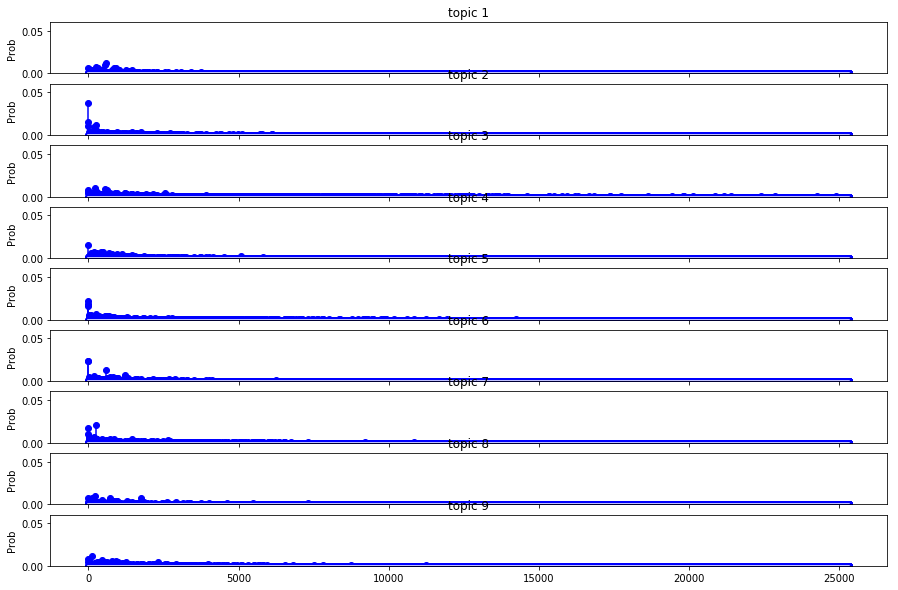

In [389]:
f, ax= plt.subplots(k, 1, figsize=(15, 10), sharex=True)  
for i, l in enumerate(range(k)):  
    ax[i].stem(beta_post[l,:], linefmt='b-',  
               markerfmt='bo', basefmt='w-')   
    #ax[i].set_xlim(-50,4350)  
    ax[i].set_ylim(0, 0.06)
    ax[i].set_ylabel("Prob")  
    ax[i].set_title("topic {}".format(l+1))  
  
ax[9].set_xlabel("word")  
  
plt.tight_layout()  
plt.show()  
pass
plt.savefig('real_10.jpg')

In [302]:
f, ax= plt.subplots(k, 1, figsize=(8, 6), sharex=True)  
for i, l in enumerate(range(k)):  
    ax[i].stem(ans_real_world[1][l,:], linefmt='b-',  
               markerfmt='bo', basefmt='w-')   
    #ax[i].set_xlim(-50,4350)  
    ax[i].set_ylim(0, 0.08)
    ax[i].set_ylabel("Prob")  
    ax[i].set_title("topic {}".format(l))  
  
ax[3].set_xlabel("word")  
  
plt.tight_layout()  
plt.show()  
pass
plt.savefig('real_word.jpg')

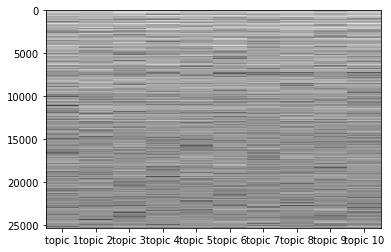

In [461]:
plt.imshow(np.log(100*ans_real_world[1]**(3)).T, cmap=plt.cm.gray,interpolation='nearest', aspect='auto')
# cmap=plt.cm.cool
# cmap=plt.cm.hot
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9], 
["topic 1", "topic 2","topic 3", "topic 4","topic 5","topic 6","topic 7","topic 8","topic 9","topic 10"])
pass

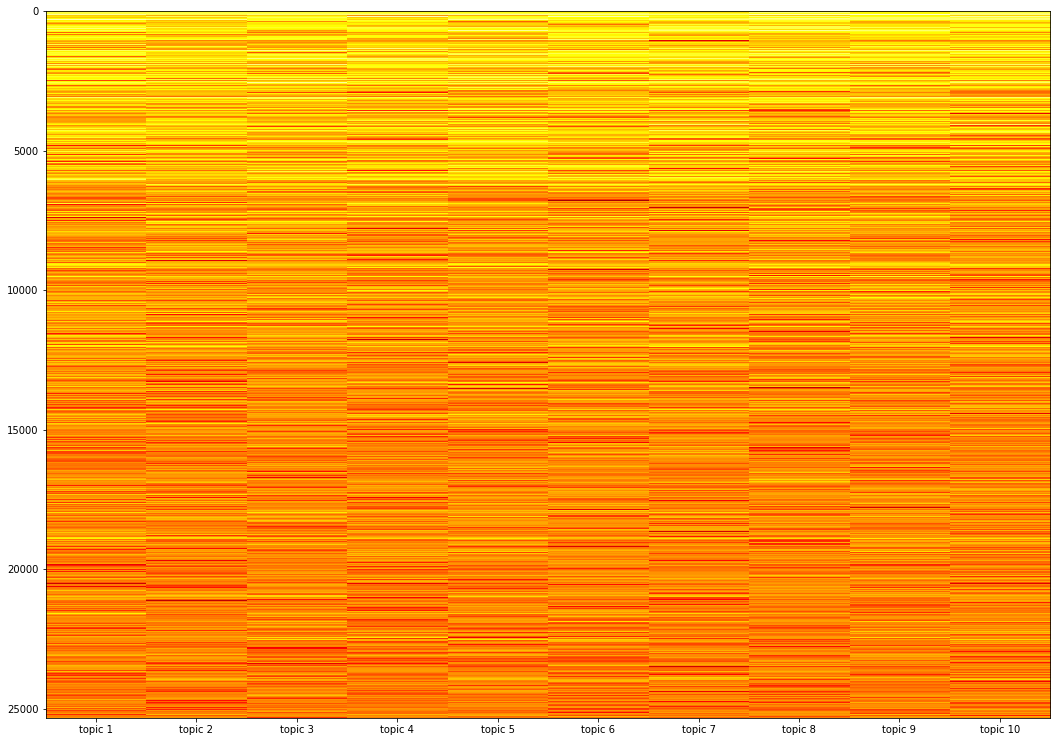

In [456]:
fig, ax = plt.subplots(figsize=(18,13))
ax.imshow(np.log(10000*ans_real_world[1]).T, cmap=plt.cm.hot,interpolation='nearest', aspect='auto')
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9], 
["topic 1", "topic 2","topic 3", "topic 4","topic 5","topic 6","topic 7","topic 8","topic 9","topic 10"])
pass

In [377]:
gamma_post = ans_real_world[2]/np.sum(ans_real_world[2],axis = 1).reshape((-1,1))


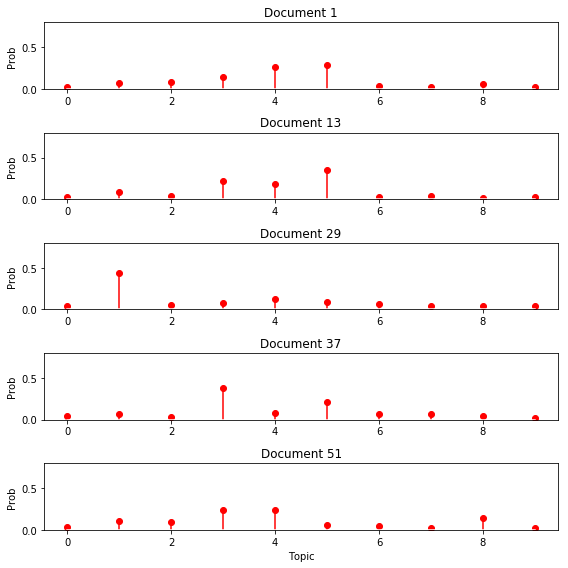

In [422]:
f, ax= plt.subplots(5, 1, figsize=(8, 8), sharex=False)  
for i, k in enumerate([1, 13, 29, 37, 51]):  
    ax[i].stem(gamma_post[k,:], linefmt='r-',  
               markerfmt='ro', basefmt='w-')  
    #ax[i].set_xlim(-1, 21)  
    ax[i].set_ylim(0, 0.8)  
    ax[i].set_ylabel("Prob")  
    ax[i].set_title("Document {}".format(k))  
  
ax[4].set_xlabel("Topic")  
  
plt.tight_layout() 